# Clustering Analysis of Single-Cell Feature Data

This notebook explores clustering methods applied to high-content single-cell morphological data. The main goals are to:

- Apply **dimensionality reduction** techniques (PCA, LDA, t-SNE and UMAP) to better visualize and preprocess the data
- Use **unsupervised clustering algorithms** (K-Means, Gaussian Mixture Models, and DBSCAN) to group cells based on morphological similarity
- Compare clustering performance using **silhouette scores**
- Visualize clustering results in 2D space using PCA projections

The data contains numeric features extracted from single-cell images. Each cell is also labeled with its treatment class, which is used for evaluation (not clustering itself).

This workflow illustrates how dimensionality reduction and clustering techniques can help uncover patterns and structure in high-dimensional biological data.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## Load the Data

We begin by loading the dataset containing single-cell morphological features extracted from Cell Painting images. Each row represents a single cell, and each column corresponds to a numeric feature such as intensity, texture, or shape. The dataset also includes a `class` label indicating the compound treatment.

We preview the first 10 rows below to understand the structure of the data.


In [2]:
# Load the data
df = pd.read_csv("../data_day2-3/JUMP-CP_mini/processed/features_cells.csv")
df.head(10)

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,convex_area,eccentricity,equivalent_diameter,...,weighted_centroid-1-0,weighted_centroid-1-1,mean_intensity-0,mean_intensity-1,max_intensity-0,max_intensity-1,min_intensity-0,min_intensity-1,filename,class
0,1,1497.0,0,0,48,33,1584.0,1525.0,0.730636,43.658213,...,15.003877,14.569091,8.097528,16.286573,31.0,34.0,3.0,6.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
1,2,6007.0,0,20,147,117,14259.0,7613.0,0.940005,87.454845,...,71.466531,70.593976,7.274347,16.178458,51.0,76.0,0.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
2,3,5054.0,0,133,103,273,14420.0,5700.0,0.973577,80.218157,...,211.461375,208.446558,12.022952,28.860309,29.0,135.0,0.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
3,4,2899.0,0,183,79,274,7189.0,3199.0,0.950572,60.754600,...,235.466314,236.302064,13.711625,35.690928,27.0,121.0,0.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
4,5,927.0,0,244,31,290,1426.0,984.0,0.718493,34.355393,...,264.799194,264.032510,13.381877,32.683927,34.0,117.0,1.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
5,6,3368.0,0,358,53,451,4929.0,3618.0,0.885541,65.484890,...,406.857720,409.168438,9.770487,21.172209,27.0,65.0,0.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
6,7,1644.0,0,445,34,513,2312.0,1756.0,0.799057,45.751566,...,472.225743,471.074872,9.290754,17.588808,31.0,71.0,1.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
7,8,1950.0,0,526,64,596,4480.0,2644.0,0.891988,49.827875,...,557.457759,558.581045,12.055385,21.415897,34.0,72.0,1.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
8,9,2538.0,0,551,60,627,4560.0,2631.0,0.898312,56.846125,...,590.907692,590.805133,14.977935,26.744287,44.0,72.0,1.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like
9,10,2670.0,0,609,69,664,3795.0,2759.0,0.772159,58.305657,...,635.459383,636.114623,18.285393,27.005993,32.0,50.0,0.0,0.0,CP1-SC1-08_P06_T0001F003L01A04Z01C05.tif,Brefeldin-A-like


## Preprocessing and Feature Selection

We select only the numeric features from the dataset, excluding the label column (`label`) which is not used as input for clustering. The `class` column is stored separately for evaluation purposes.

To ensure consistency across features, we:
- Drop rows with missing values
- Standardize the features using `StandardScaler` to have zero mean and unit variance

We also compute the variance of each numeric feature to identify those that contribute most to variability in the dataset. Below, we display the top 10 features with the highest variance.


In [3]:
# Select only numeric features (excluding label column)
feature_cols = df.select_dtypes(include="number").columns.drop("label")
X = df[feature_cols]
y = df["class"]

# Drop rows with missing values
X_clean = X.dropna()
y_clean = y[X_clean.index]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Calculate variance for each numeric column (excluding 'label')
variances = X.var().sort_values(ascending=False)

# Display the top features with the highest variance
variances.head(10)
#print(df.columns.tolist())



bbox_area                2.357927e+07
convex_area              8.680946e+06
area                     6.177445e+06
filled_area              6.177445e+06
weighted_centroid-1-0    1.421687e+05
weighted_centroid-1-1    1.397388e+05
bbox-3                   1.396717e+05
centroid-1               1.395239e+05
bbox-1                   1.392814e+05
bbox-2                   1.041825e+05
dtype: float64

## Visualize Two Morphological Features

To explore the dataset visually, we create a 2D scatter plot using two selected morphological features:

- `bbox_area`: likely related to the size or bounding box of the cell
- `eccentricity`: a measure of cell shape (e.g., how elongated the object is)

Each point represents a single cell, and colors correspond to the compound treatment (`class`). This allows us to visually assess how well the selected features separate the different treatments.

You can modify `x_feature` and `y_feature` to explore other feature combinations.


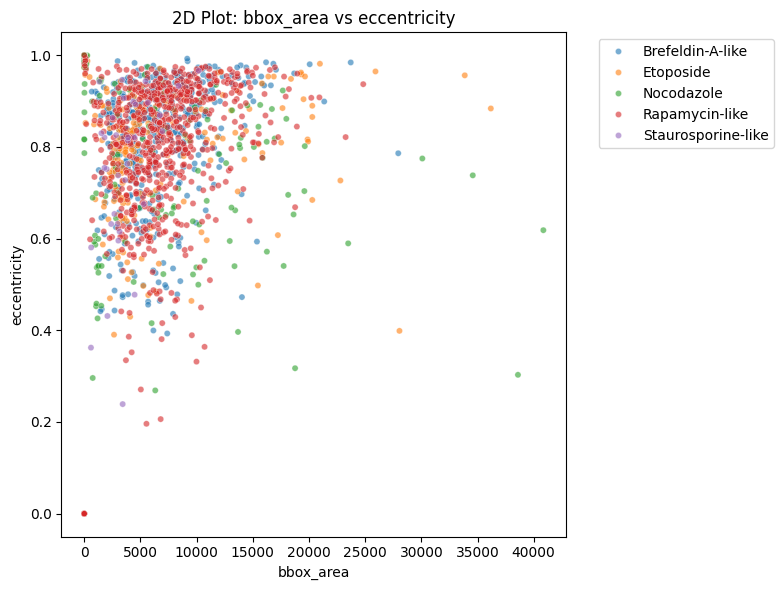

In [4]:
# Define features to plot
x_feature = "bbox_area"           # can be changed 
y_feature = "eccentricity"      # can be changed

# Check that features are valid
if x_feature in df.columns and y_feature in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x=x_feature, 
        y=y_feature, 
        hue="class", 
        alpha=0.6, 
        s=20, 
        palette="tab10"
    )
    plt.title(f"2D Plot: {x_feature} vs {y_feature}")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("One or both of the selected features do not exist in the dataset.")

## PCA Projection of Single-Cell Features

We apply Principal Component Analysis (PCA) to reduce the high-dimensional feature space to 2 dimensions for visualization. PCA identifies directions (principal components) that capture the most variance in the data.

In this 2D scatter plot:
- Each point represents a single cell
- Colors correspond to the compound treatment class
- The axes show the first two principal components, annotated with the percentage of variance they explain

This projection helps us understand how separable the different treatments are based on the extracted morphological features.


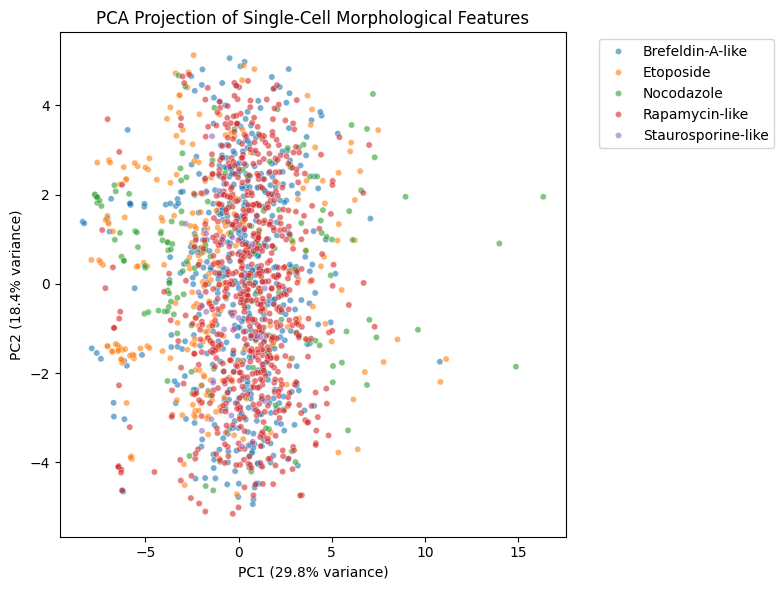

In [5]:
# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["class"] = y_clean.values

# Plot the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="class",
    alpha=0.6,
    s=20,
    palette="tab10"
)
plt.title("PCA Projection of Single-Cell Morphological Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## LDA Projection of Single-Cell Features

We apply Linear Discriminant Analysis (LDA) to project the high-dimensional feature space into 2 dimensions. Unlike PCA, which is unsupervised, LDA is a supervised dimensionality reduction method that uses class labels to find axes that maximize class separation.

In this plot:
- Each point represents a single cell
- Colors indicate the compound treatment class
- The axes correspond to the first two linear discriminants (LD1 and LD2)

LDA is particularly effective when the goal is to visualize how well-defined the classes are in the feature space.


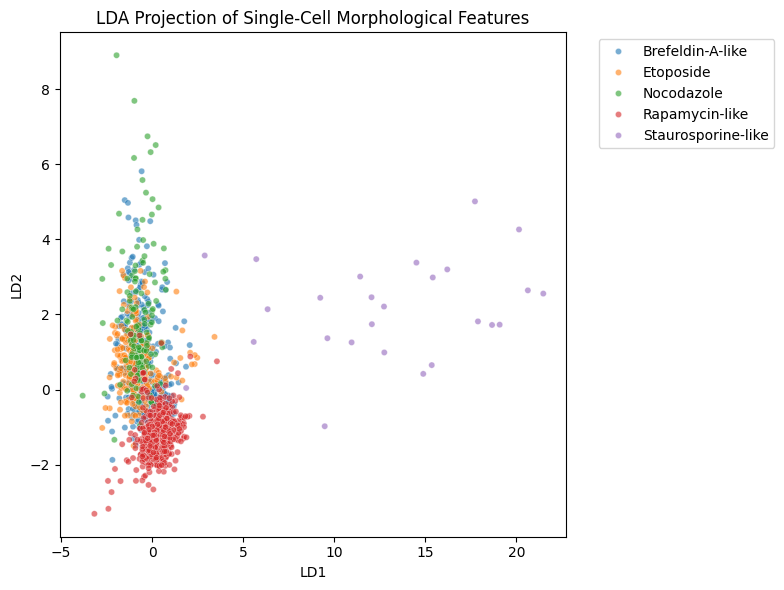

In [7]:
# Drop rows with NaNs from X and align y
#X_clean = X.dropna()
#y_clean = y[X_clean.index]

# Apply LDA to reduce to 2D
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_clean)

# Create DataFrame for plotting
lda_df = pd.DataFrame(X_lda, columns=["LD1", "LD2"])
lda_df["class"] = y_clean.values

# Plot the LDA result
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=lda_df,
    x="LD1",
    y="LD2",
    hue="class",
    alpha=0.6,
    s=20,
    palette="tab10"
)
plt.title("LDA Projection of Single-Cell Morphological Features")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Interactive 3D LDA Projection

To better capture the variance across multiple classes, we apply Linear Discriminant Analysis (LDA) with 3 components. This allows us to visualize the data in three discriminant dimensions.

In this interactive 3D plot:
- Each point represents a single cell
- Colors represent the compound treatment class
- The axes correspond to the first three linear discriminants (LD1, LD2, LD3)

This view can reveal more complex relationships between treatments that aren't visible in 2D. Use your mouse or trackpad to rotate, zoom, and explore the data from different angles.


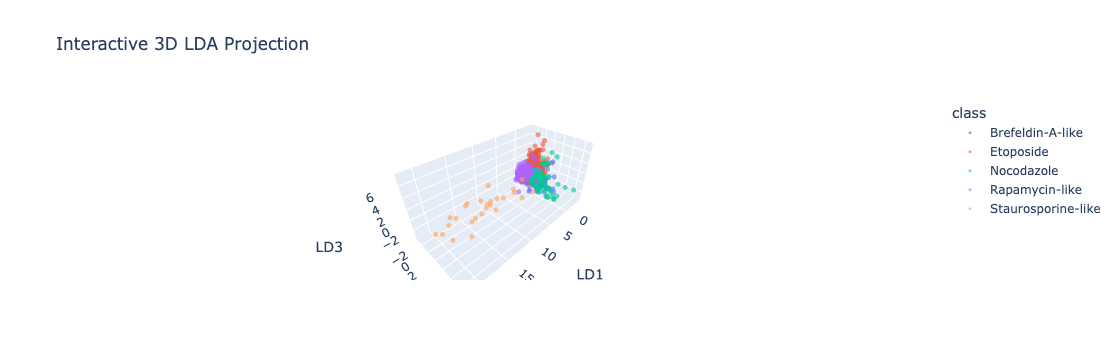

In [8]:
# Apply LDA (again, to ensure clean copy)
lda_3d = LDA(n_components=3)
X_lda_3d = lda_3d.fit_transform(X_scaled, y_clean)

# Prepare DataFrame for plot
lda3d_df = pd.DataFrame(X_lda_3d, columns=["LD1", "LD2", "LD3"])
lda3d_df["class"] = y_clean.values

# Create 3D scatter plot
fig = px.scatter_3d(
    lda3d_df,
    x="LD1", y="LD2", z="LD3",
    color="class",
    opacity=0.6,
    title="Interactive 3D LDA Projection"
)

fig.update_traces(marker=dict(size=3))
fig.show()


## t-SNE Projection of Single-Cell Features

We apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to project the high-dimensional feature space into 2 dimensions for visualization.

t-SNE is a nonlinear dimensionality reduction technique that preserves local structure, i.e., it places similar cells close together in the embedded space. It is especially useful when PCA or LDA fail to reveal meaningful clusters.

In this scatter plot:
- Each point represents a single cell
- Colors reflect the compound treatment class
- Axes `TSNE1` and `TSNE2` correspond to the t-SNE embedded dimensions (not actual features)

This method helps explore the intrinsic structure of the data, even when clusters are not linearly separable.


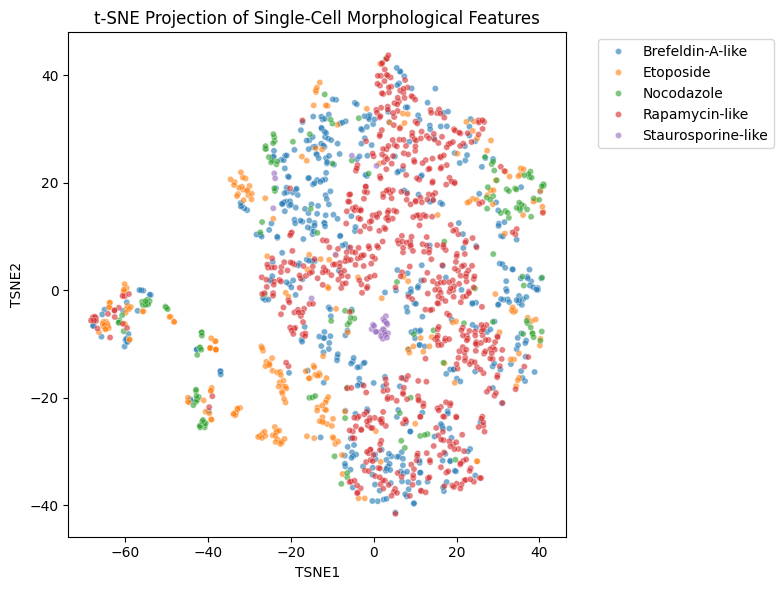

In [9]:
# Apply t-SNE to reduce to 2D (after dropping NaNs as before)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["class"] = y_clean.values

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="class",
    alpha=0.6,
    s=20,
    palette="tab10"
)
plt.title("t-SNE Projection of Single-Cell Morphological Features")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## UMAP Projection of Single-Cell Features

We use UMAP (Uniform Manifold Approximation and Projection) to reduce the feature space to 2 dimensions for visualization. UMAP is a nonlinear technique that preserves both local and global structure in the data.

In this 2D plot:
- Each point represents a single cell
- Colors indicate the compound treatment class
- The axes (`UMAP1`, `UMAP2`) are abstract dimensions capturing structure in the high-dimensional space

UMAP often creates more compact and well-separated clusters than t-SNE, while being faster and scalable to larger datasets. It is particularly useful in biological applications like single-cell analysis.


/opt/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



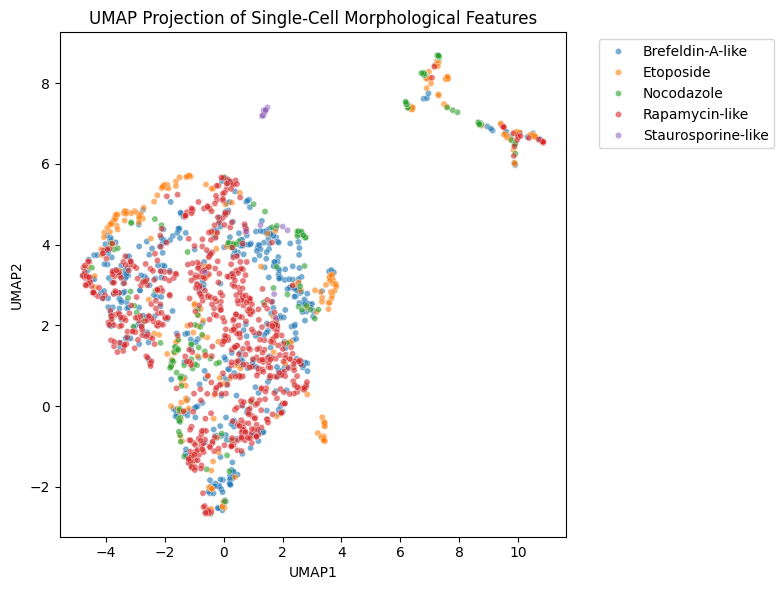

In [10]:
# Apply UMAP to reduce to 2D
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Create a DataFrame for plotting
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
umap_df["class"] = y_clean.values

# Plot the UMAP result
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP2",
    hue="class",
    alpha=0.6,
    s=20,
    palette="tab10"
)
plt.title("UMAP Projection of Single-Cell Morphological Features")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Clustering with K-Means, GMM, and DBSCAN

We apply three unsupervised clustering algorithms to the standardized feature set:

- **K-Means**: Partitions the data into a predefined number of clusters by minimizing intra-cluster variance.
- **Gaussian Mixture Models (GMM)**: Models each cluster as a probabilistic Gaussian distribution, allowing for soft assignments.
- **DBSCAN**: A density-based method that groups densely packed points and identifies outliers as noise.

To evaluate the quality of clustering, we calculate the **Silhouette Score** for each method, which measures how similar a point is to its own cluster compared to other clusters:
- Values range from **-1** (poor clustering) to **+1** (well-clustered).
- A higher score indicates better-defined clusters.

The dictionary below summarizes the silhouette scores for all methods.


In [11]:
# Standardize features

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

# GMM clustering
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Check for valid silhouette calculation (at least 2 clusters)
if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
    dbscan_silhouette = silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
elif len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
else:
    dbscan_silhouette = None  # silhouette score is not defined

# Display silhouette scores
{
    "KMeans Silhouette Score": kmeans_silhouette,
    "GMM Silhouette Score": gmm_silhouette,
    "DBSCAN Silhouette Score": dbscan_silhouette
}


{'KMeans Silhouette Score': 0.16776835301242085,
 'GMM Silhouette Score': 0.06238918390475371,
 'DBSCAN Silhouette Score': 0.37054153855077465}

## Visual Comparison of Clustering Results (PCA View)

Visualization of the clustering results from the three algorithms K-Means, GMM and DBSCAN, projected onto the first two principal components (PC1 and PC2)

Each subplot shows:
- Points representing individual cells
- Colors indicating the cluster assignment by the algorithm

This PCA view allows us to qualitatively assess how well each method separates the data in 2D space. For example:
- **K-Means** typically forms circular clusters
- **GMM** allows for elliptical or overlapping groups
- **DBSCAN** can capture irregular shapes and detect outliers (shown as a unique color or label)


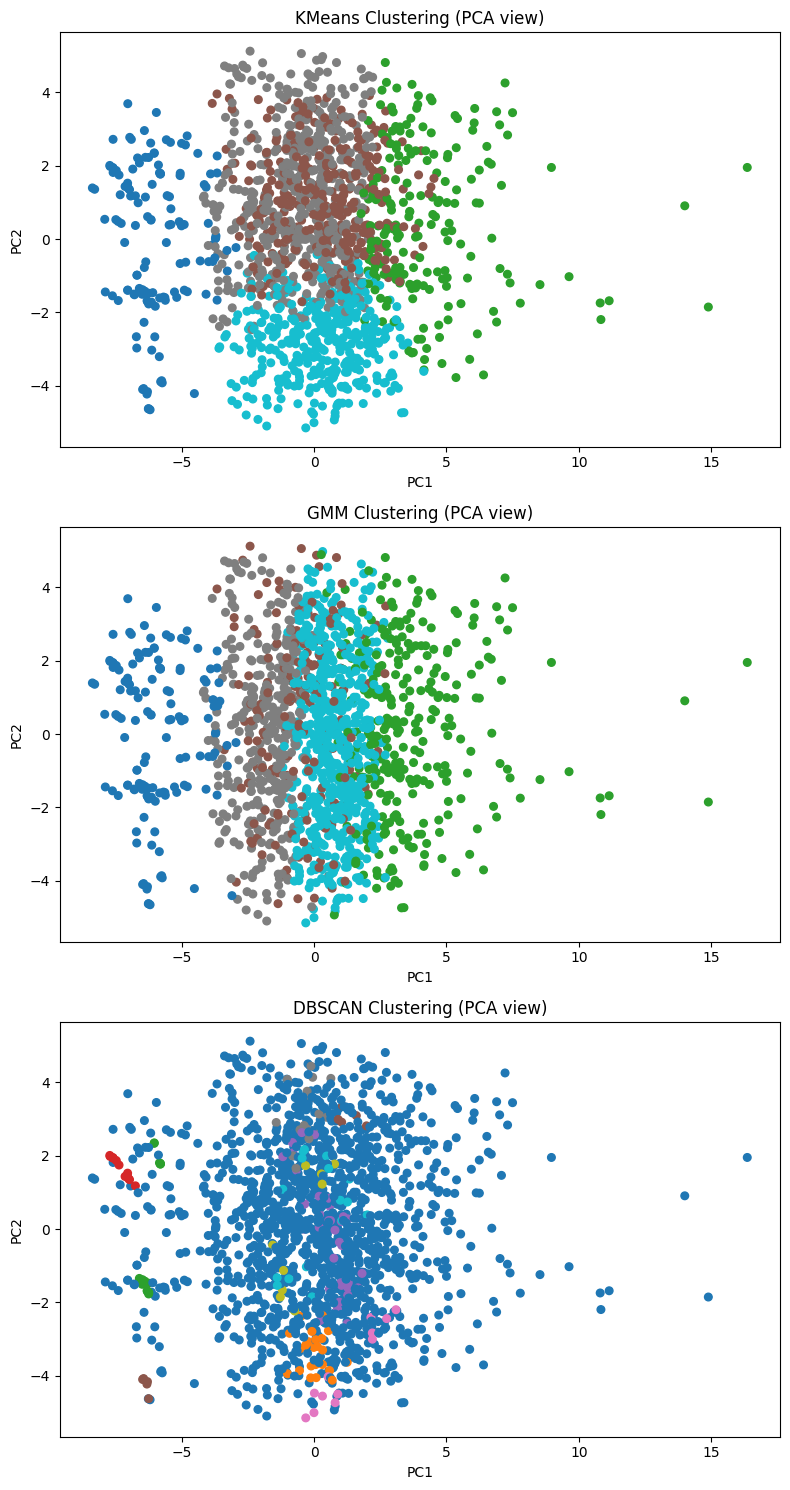

In [12]:

# Create individual plots for each clustering method
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# KMeans
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=30)
axs[0].set_title("KMeans Clustering (PCA view)")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

# GMM
axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='tab10', s=30)
axs[1].set_title("GMM Clustering (PCA view)")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")

# DBSCAN
axs[2].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10', s=30)
axs[2].set_title("DBSCAN Clustering (PCA view)")
axs[2].set_xlabel("PC1")
axs[2].set_ylabel("PC2")

plt.tight_layout()
plt.show()


## Clustering Results Visualized in LDA Space

Visualization of the clustering results using the first two **Linear Discriminants (LD1 and LD2)** obtained via **LDA**.

Each subplot shows:
- A 2D projection of the cells in LDA space, which maximizes class separability
- Cluster assignments from:
  - **K-Means**
  - **GMM**
  - **DBSCAN**
- A legend indicating the cluster each color represents

Because LDA is supervised and aligns with class structure, it helps us visually assess how well the clustering methods recover class boundaries, especially useful when true class labels are available.


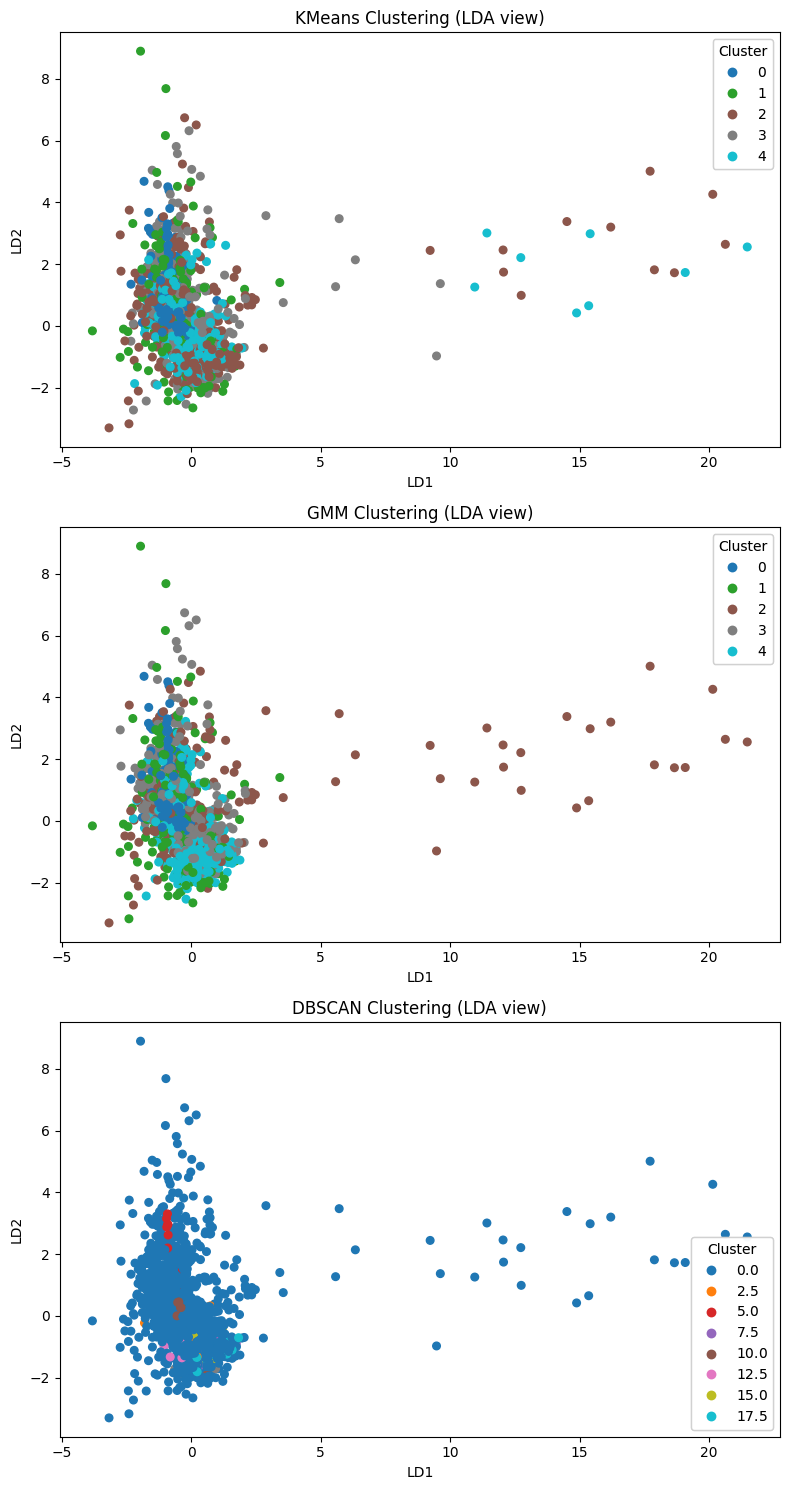

In [15]:
# Add legends to the clustering plots in LDA space

fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# KMeans with legend
scatter_kmeans = axs[0].scatter(X_lda[:, 0], X_lda[:, 1], c=kmeans_labels, cmap='tab10', s=30)
axs[0].set_title("KMeans Clustering (LDA view)")
axs[0].set_xlabel("LD1")
axs[0].set_ylabel("LD2")
legend1 = axs[0].legend(*scatter_kmeans.legend_elements(), title="Cluster")
axs[0].add_artist(legend1)

# GMM with legend
scatter_gmm = axs[1].scatter(X_lda[:, 0], X_lda[:, 1], c=gmm_labels, cmap='tab10', s=30)
axs[1].set_title("GMM Clustering (LDA view)")
axs[1].set_xlabel("LD1")
axs[1].set_ylabel("LD2")
legend2 = axs[1].legend(*scatter_gmm.legend_elements(), title="Cluster")
axs[1].add_artist(legend2)

# DBSCAN with legend
scatter_dbscan = axs[2].scatter(X_lda[:, 0], X_lda[:, 1], c=dbscan_labels, cmap='tab10', s=30)
axs[2].set_title("DBSCAN Clustering (LDA view)")
axs[2].set_xlabel("LD1")
axs[2].set_ylabel("LD2")
legend3 = axs[2].legend(*scatter_dbscan.legend_elements(), title="Cluster")
axs[2].add_artist(legend3)

plt.tight_layout()
plt.show()
